In [1]:
#Import deps 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

.... Some Introductory Text 

In [2]:
# Import Data 
all_wine_raw_df = pd.read_csv('./Wine_data_both.csv') 
red_wine_df = pd.read_csv('./Wine_data_red.csv')
white_wine_df = pd.read_csv('./Wine_data_white.csv')

In [3]:
# Previewing Data
display(all_wine_raw_df)
display(all_wine_raw_df['quality'].value_counts())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Wine
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,White
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,White
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,White
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,White
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,Red
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,Red
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,Red
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,Red


quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [4]:
# Encode Wine column using get_dummies
wine_categories = pd.get_dummies(all_wine_raw_df['Wine'],dtype=int)
wine_categories.value_counts()

Red  White
0    1        4898
1    0        1599
Name: count, dtype: int64

In [5]:
# Concatenate encoded wine column to main dataframe
all_wine_raw_concat = pd.concat(
    [all_wine_raw_df.drop('Wine',axis=1),wine_categories],
    join='outer',
    axis=1)
all_wine_raw_concat

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Red,White
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0,1
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,0,1
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,0,1
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0,1
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1,0
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1,0
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1,0
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1,0


In [6]:
# Setup X and y variables
X = all_wine_raw_concat.drop(columns='quality')
y = all_wine_raw_concat['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Red,White
count,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000,4872.000000
mean,7.210088,0.340368,0.318007,5.460211,0.055947,30.673030,115.857245,0.994704,3.219333,0.529670,10.489429,0.246921,0.753079
std,1.297567,0.164934,0.144987,4.781869,0.034602,17.980481,56.704002,0.003027,0.159228,0.147407,1.194576,0.431265,0.431265
min,3.900000,0.080000,0.000000,0.600000,0.012000,1.000000,6.000000,0.987130,2.720000,0.220000,8.000000,0.000000,0.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,78.000000,0.992300,3.110000,0.430000,9.500000,0.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994900,3.210000,0.500000,10.300000,0.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,0.000000,1.000000
max,15.600000,1.330000,1.230000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.200000,1.000000,1.000000


In [7]:
# Preprocess data - Scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Trying Random Forest Classifier

In [8]:
# Build Model 
clf = RandomForestClassifier(random_state=13)
clf.fit(X_train_scaled,y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.6873846153846154


Text(0, 0.5, 'Frequency')

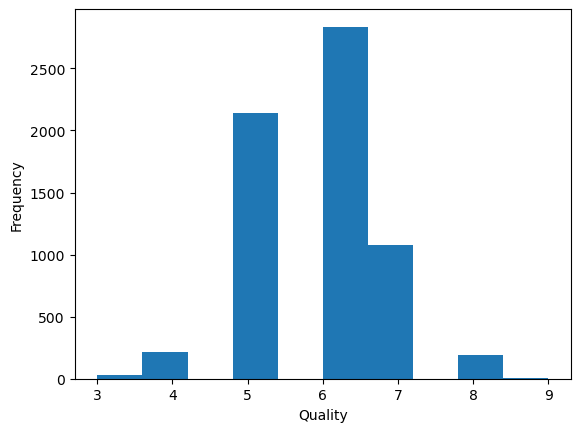

In [9]:
plt.hist(all_wine_raw_concat['quality'])
plt.xlabel('Quality')
plt.ylabel('Frequency')

In [10]:
# Evaluate and Optimize Model
# Create a loop to vary the max_depth parameter
# Make sure to record the train and test scores 
# for each pass.

# Depths should span from 1 up to 40 in steps of 2
depths = range(1, 40, 2)

# The scores dataframe will hold depths and scores
# to make plotting easy
scores = {'train': [], 'test': [], 'depth': []}

# Loop through each depth (this will take time to run)
for depth in depths:
    clf = RandomForestClassifier(max_depth=depth)
    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    scores['depth'].append(depth)
    scores['train'].append(train_score)
    scores['test'].append(test_score)

# Create a dataframe from the scores dictionary and
# set the index to depth
scores_df = pd.DataFrame(scores).set_index('depth')

scores_df.head()

,train,test
depth,,
1,0.476190,0.473231
3,0.536330,0.540923
5,0.578818,0.569231
7,0.649425,0.600000
9,0.751026,0.638154


<Axes: xlabel='depth'>

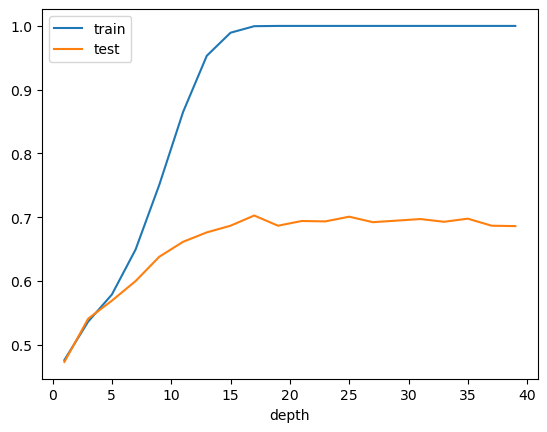

In [11]:
scores_df.plot()

In [12]:
# Get the feature importance array
feature_importances = clf.feature_importances_

In [13]:
# List the top 10 most important features
importances_sorted = sorted(zip(feature_importances, X.columns), reverse=True)
importances_sorted[:10]

[(0.11786592909533633, 'alcohol'),
 (0.10621003197117032, 'density'),
 (0.09800708741732954, 'volatile acidity'),
 (0.08954925310396238, 'total sulfur dioxide'),
 (0.08639747198017998, 'sulphates'),
 (0.08570145034648015, 'chlorides'),
 (0.08561438245406841, 'free sulfur dioxide'),
 (0.08466496061291602, 'residual sugar'),
 (0.08265861986687995, 'pH'),
 (0.0811611253546587, 'citric acid')]

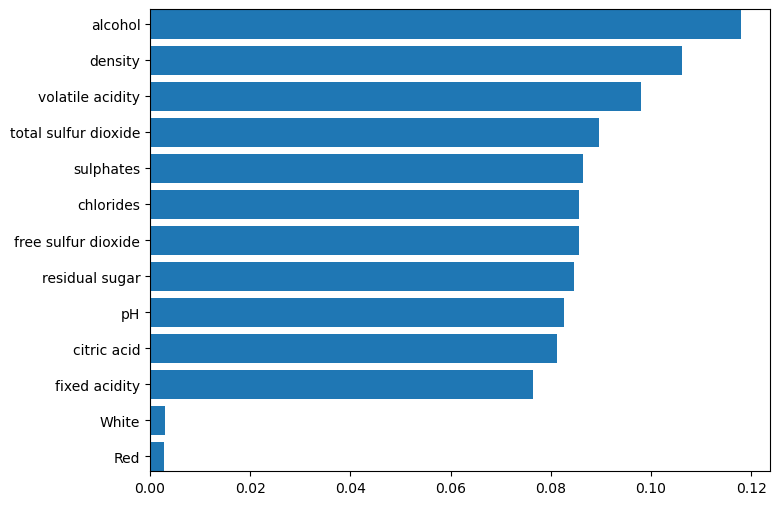

In [14]:
# Plot the feature importances
features = sorted(zip(X.columns, feature_importances), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(8,6)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

... Text interpreting and describing results 

In [15]:
no_wine_df = all_wine_raw_df.drop('Wine',axis=1)
X = no_wine_df.drop(columns='quality')
y = no_wine_df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
clf = RandomForestClassifier(random_state=13, max_depth = 25)
clf.fit(X_train,y_train)
print(f'Training Score: {clf.score(X_train, y_train)}')
print(f'Testing Score: {clf.score(X_test, y_test)}')

Training Score: 1.0
Testing Score: 0.691076923076923


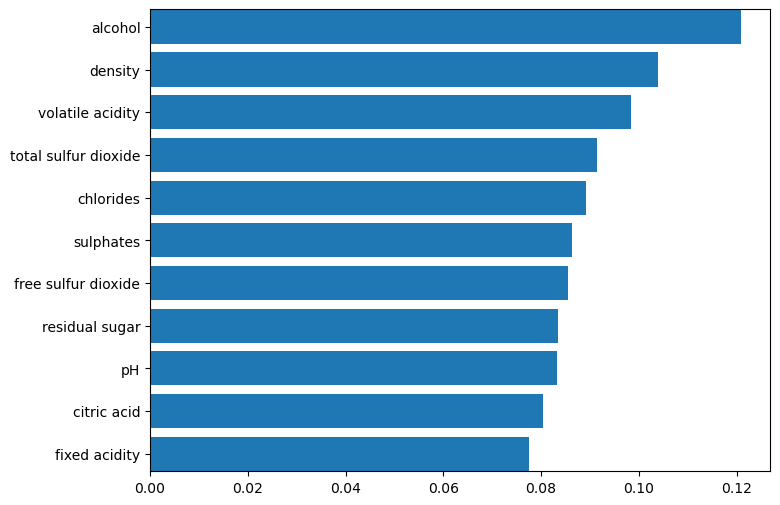

In [16]:
feature_importances = clf.feature_importances_
features = sorted(zip(X.columns, feature_importances), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(8,6)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

# Trying KNN

k: 1, Train/Test Score: 1.000/0.638
k: 3, Train/Test Score: 0.768/0.570
k: 5, Train/Test Score: 0.683/0.586
k: 7, Train/Test Score: 0.659/0.580
k: 9, Train/Test Score: 0.635/0.577
k: 11, Train/Test Score: 0.614/0.576
k: 13, Train/Test Score: 0.612/0.573
k: 15, Train/Test Score: 0.606/0.567
k: 17, Train/Test Score: 0.598/0.574
k: 19, Train/Test Score: 0.597/0.573


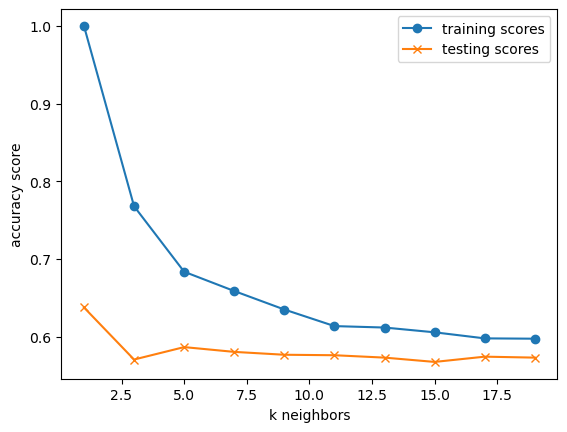

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
# Plot the results
plt.plot(range(1, 20, 2), train_scores, marker='o', label="training scores")
plt.plot(range(1, 20, 2), test_scores, marker="x", label="testing scores")
plt.xlabel("k neighbors")
plt.ylabel("accuracy score")
plt.legend()
plt.show()

In [18]:
# Train the KNN model with the best k value
# Note that k: 5 seems to be the best choice for this dataset
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
print('k=5 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=5 Test Acc: 0.586


# Trying Decision Tree

In [19]:
from sklearn import tree
from sklearn.metrics import accuracy_score
decision_tree = tree.DecisionTreeClassifier().fit(X_train_scaled,y_train)
predictions = decision_tree.predict(X_test_scaled)
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.6172307692307692


# Binning - Feature Engineering

In [32]:
no_wine_df['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [50]:
def classify_quality(quality):
    if (quality == 7 or quality == 8 or quality == 9): 
        return 'High'
    elif (quality == 3 or quality == 4): 
        return 'Low'
    elif (quality > 4 and quality < 7): 
        return 'Mid'
        
no_wine_df['Classification'] = no_wine_df['quality'].apply(classify_quality)
no_wine_df = no_wine_df.drop(columns = ['quality'])
no_wine_df['Classification'].value_counts()

Classification
Mid     4974
High    1277
Low      246
Name: count, dtype: int64

In [52]:

X = no_wine_df.drop(columns=['Classification'])
y = no_wine_df['Classification']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

clf = RandomForestClassifier(random_state=13)
clf.fit(X_train_scaled,y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.8683076923076923


In [11]:
# Export Results